# Simple regression with bayesian neural networks

In this notebook you will find a comparison between two bayesian methods to assess uncertainty when dealing with neural networks: **Monte-Carlo Dropout** (["Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)) and **Bayesian by Backpropagation** (["Weight Uncertainty in Neural Networks"](https://arxiv.org/abs/1505.05424)). We study a very simple toy regression model in 1D.

In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

import torch
from torch.utils import data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Data preparation

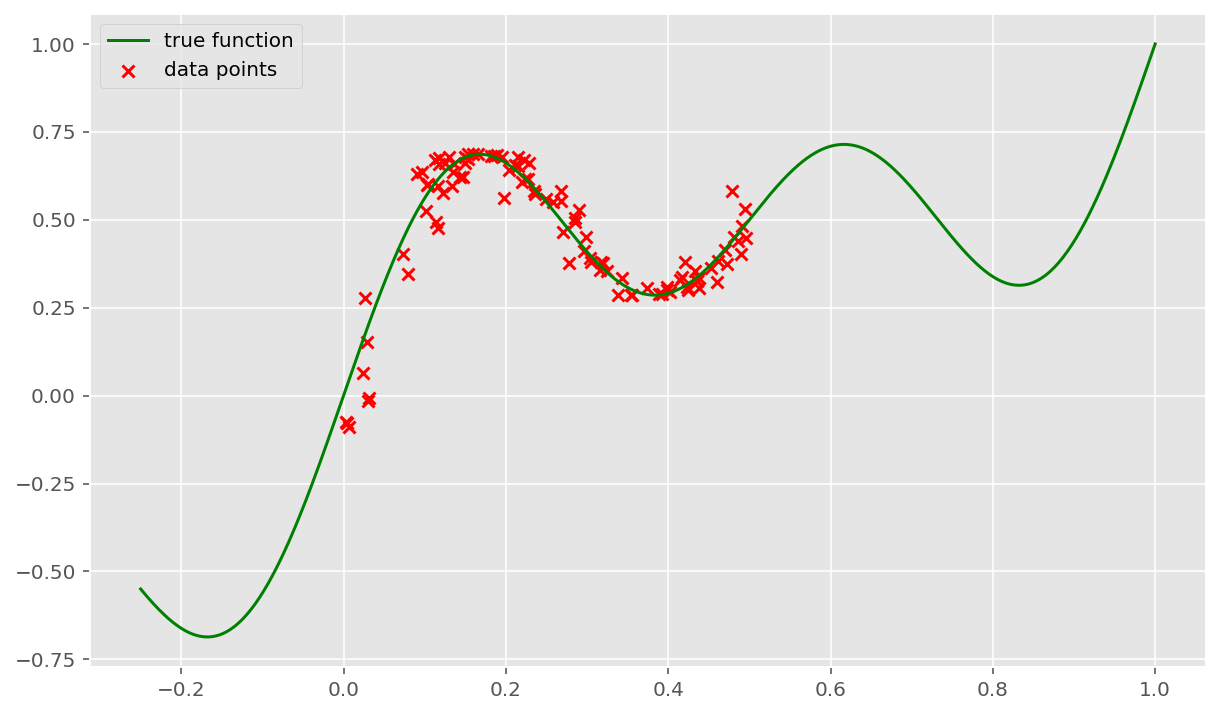

In [28]:
N = 100  #number of training data points
sigma = 0.02
dataset = {}

def function(x , epsilon):
    return x + 0.3 * np.sin(2 * np.pi * (x + epsilon)) + 0.3 * np.sin(4 * np.pi * (x + epsilon)) + epsilon

dataset['X_train'] = np.random.uniform(0 , 0.5 , N)
dataset['y_train'] = function(dataset['X_train'] , np.random.normal(0 , sigma , N))

dataset['X_test'] = np.linspace(-0.25 , 1 , 1000)
F = function(dataset['X_test'] , 0)

plt.figure(figsize = (10 , 6))
plt.plot(dataset['X_test'] , F , color = 'green' , label = 'true function')
plt.scatter(dataset['X_train'] , dataset['y_train'] , marker = 'x' , color = 'red' , label = 'data points')
plt.legend()
plt.title("Data")
plt.show()

In [29]:
X_train_tensor = torch.from_numpy(dataset['X_train'].copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(dataset['y_train'].copy()).float()
X_test_tensor = torch.from_numpy(dataset['X_test'].copy()).float().unsqueeze(dim=1)

## 1. Deterministic regression

In [30]:
import models.deterministic_regression as dreg

##### Definition of the model

In [31]:
net = dreg.DeterministicNet(hidden_size = 100 , dim_input = 1 , dim_output = 1)
reg_model = dreg.DeterministicReg(X_train_tensor , y_train_tensor , X_test_tensor , net)

##### Training step

In [32]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000 , optimizer , criterion , batch = False)

##### Test step

In [33]:
y_pred = reg_model.predict()

##### Plot results

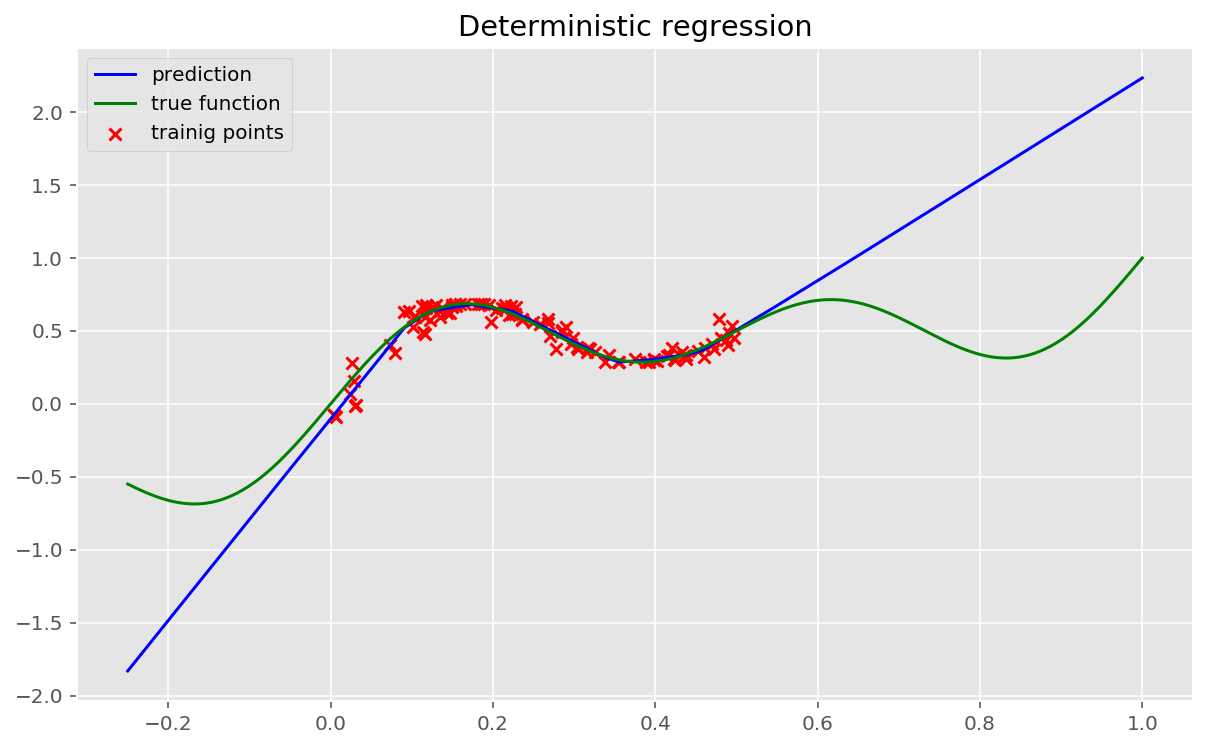

In [35]:
plt.figure(figsize = (10 , 6))
reg_model.plot_results()
plt.plot(dataset['X_test'] , F , color = 'green' , label = 'true function')
plt.legend()
plt.title('Deterministic regression')
plt.show()

## 2. Bayesian regression with Monte-Carlo dropout

In [9]:
import models.dropout_regression as doreg

In [10]:
## Definition of the model
net = doreg.DropoutNet(hidden_size = 100 , dim_input = 1 , dim_output = 1 , p = 0.25)
reg_model = doreg.DropoutReg(X_train_tensor , y_train_tensor , X_test_tensor , net , batch_size = X_train_tensor.shape[0])

In [11]:
## Training step
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000 , optimizer , criterion)

In [12]:
## Test step
y_pred_mean , y_pred_std = reg_model.predict(samples = 1000)

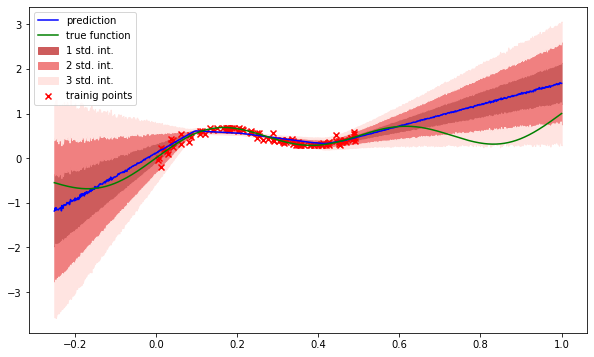

In [13]:
## Plot results
plt.figure(figsize = (10 , 6))
reg_model.plot_results()
plt.plot(dataset['X_test'] , F , color = 'green' , label = 'true function')
plt.legend()

## 3. Bayesian regression with Bayesian by Backpropagation

In [14]:
import models.bayesbackprop_regression as bbb

In [15]:
## Definition of the model
prior_parameters = {'sigma1': 1, 'sigma2': np.exp(-6) , 'pi': 0.5}
net = bbb.BayesBackpropNet(hidden_size = 100 , dim_input = 1 , dim_output = 1 
                           , prior_parameters = prior_parameters ,sigma = 0.02)
reg_model = bbb.BayesBackpropReg(X_train_tensor , y_train_tensor , X_test_tensor , net , batch_size = 10)

In [16]:
## Training step
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(100 , optimizer , 10)

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [17]:
## Test step
y_pred_mean , y_pred_std = reg_model.predict(samples = 1000)

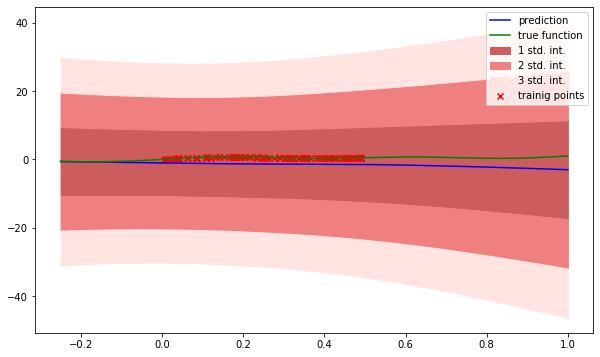

In [18]:
## Plot results
plt.figure(figsize = (10 , 6))
reg_model.plot_results()
plt.plot(dataset['X_test'] , F , color = 'green' , label = 'true function')
plt.legend()